In [4]:
#!pip install hopsworks==4.1.3
#!pip install requests_cache
#!pip install retry_requests
#!pip install google_play_scraper
import sys
sys.path.append('../')

In [5]:
import datetime
import time
import requests
import pandas as pd
import hopsworks
from functions import util
import json
import os
import warnings
warnings.filterwarnings("ignore")

2025-01-10 10:59:59.191323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 10:59:59.240427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 10:59:59.255545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 10:59:59.290257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-10 11:00:02.700712: W tensorflow/compiler/tf2

In [6]:
# Create directories for saving model artifacts
model_dir = "../reviews_sentiment_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [7]:
os.environ["HOPSWORKS_API_KEY"] = "6xLHrUPek6nw9STy.ueYbHCnUwYhFQ5xzscRiONFQ4ZmgUxMFUt8bnCu3UX69ejYcaIxeUHynvrMhcrt5"

project = hopsworks.login()
fs = project.get_feature_store()

2025-01-10 11:00:12,935 INFO: Initializing external client
2025-01-10 11:00:12,937 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-10 11:00:14,521 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1185941


In [8]:
reviews_fg = fs.get_feature_group(
    name='reviews',
    version=1,
)

In [9]:
df = reviews_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.55s) 


In [10]:
df

,reviewid,content,score,at,thumbsupcount,augmented_comment,sentiment
0,ed92cde4-7c1d-4011-b229-c60df1f034fa,Won't allow me to delete the account.,1,2024-07-16 09:30:12+00:00,1,Won't allow me to delete the account.. Score g...,positive
1,3e3bd196-9c70-413e-bcf6-1763782842cc,nice,5,2024-07-11 01:09:44+00:00,0,nice. Score given on a scale of 1 to 5 is: 5,positive
2,3c16071f-2e1a-4302-af87-4e3b274f6e71,good,5,2024-07-06 23:20:29+00:00,0,good. Score given on a scale of 1 to 5 is: 5,positive
3,f59582e9-ebb0-4527-83d3-7de98c38ea40,"use better hinge, tinder anymore nothing in Ge...",1,2024-09-13 12:40:36+00:00,1,"use better hinge, tinder anymore nothing in Ge...",positive
4,459e063c-e782-4cdb-a960-85fa4394dacc,good,5,2024-10-24 21:30:28+00:00,0,good. Score given on a scale of 1 to 5 is: 5,positive
...,...,...,...,...,...,...,...
29989,067098b1-0d69-43a5-a196-fc43a0bfd89b,"it's good , i wish the app wAs free",5,2024-07-12 14:12:47+00:00,0,"it's good , i wish the app wAs free. Score giv...",positive
29990,bcde5e68-c34f-43d1-9d9b-c4d127228245,none,4,2024-12-07 00:32:24+00:00,0,none. Score given on a scale of 1 to 5 is: 4,neutral
29991,623dd1a3-3feb-47be-a219-42faa649a5a1,it's great,5,2024-12-28 14:47:25+00:00,0,it's great. Score given on a scale of 1 to 5 i...,positive
29992,da147881-9479-4246-9784-9dedcb2bb516,"Locked me out of my own account, forced a phot...",1,2024-10-22 23:48:45+00:00,0,"Locked me out of my own account, forced a phot...",negative


# Preprocessing the data

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29994 entries, 0 to 29993
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype                  
---  ------             --------------  -----                  
 0   reviewid           29994 non-null  object                 
 1   content            29994 non-null  object                 
 2   score              29994 non-null  int64                  
 3   at                 29994 non-null  datetime64[us, Etc/UTC]
 4   thumbsupcount      29994 non-null  int64                  
 5   augmented_comment  29994 non-null  object                 
 6   sentiment          29994 non-null  object                 
dtypes: datetime64[us, Etc/UTC](1), int64(2), object(4)
memory usage: 1.6+ MB


In [13]:
# Reformatting columns
df['augmented_comment'] = df['augmented_comment'].astype(str)  # Convert 'augmented_comment' to string
df['sentiment'] = df['sentiment'].astype(str)  # Convert 'sentiment' to string
df['content'] = df['content'].astype(str)  # Convert 'content' to string

In [14]:
df = df[['sentiment','content', 'score']]

In [15]:
df['sentiment'].value_counts()

sentiment
positive    15035
negative    11979
neutral      2980
Name: count, dtype: int64

In [16]:
# Drop rows where sentiment is 'neutral'
df = df[df['sentiment'] != 'neutral']

# Map 'positive' to 1 and 'negative' to 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Verify the changes
df['sentiment'].value_counts()

sentiment
1    15035
0    11979
Name: count, dtype: int64

In [17]:
import nltk
nltk.download('stopwords')
## remove stopwords and punctuation marks
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)

corpus = df['content'].tolist()
print(len(corpus))
print(corpus[0])

27014
Won't allow me to delete the account.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jouteix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
%%time
nltk.download('wordnet')
final_corpus = []
final_corpus_joined = []
for i in df.index:

    text = re.sub('[^a-zA-Z]', ' ', df['content'][i])
    #Convert to lowercase
    text = text.lower()

    ##Convert to list from string
    text = text.split()

    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text
            if not word in stuff_to_be_removed]
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

[nltk_data] Downloading package wordnet to /home/jouteix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CPU times: user 14.5 s, sys: 317 ms, total: 14.8 s
Wall time: 14.7 s


In [19]:
data_cleaned = pd.DataFrame()
data_cleaned["content"] = final_corpus_joined
data_cleaned["sentiment"] = df["sentiment"].values

In [20]:
data_eda = pd.DataFrame()
data_eda['content'] = final_corpus
data_eda['sentiment'] = df["sentiment"].values

# Storing positive data seperately
positive = data_eda[data_eda['sentiment'] == 1]
positive_list = positive['content'].tolist()

# Storing negative data seperately
negative = data_eda[data_eda['sentiment'] == 0]
negative_list = negative['content'].tolist()

positive_all = " ".join([word for sent in positive_list for word in sent ])
negative_all = " ".join([word for sent in negative_list for word in sent ])

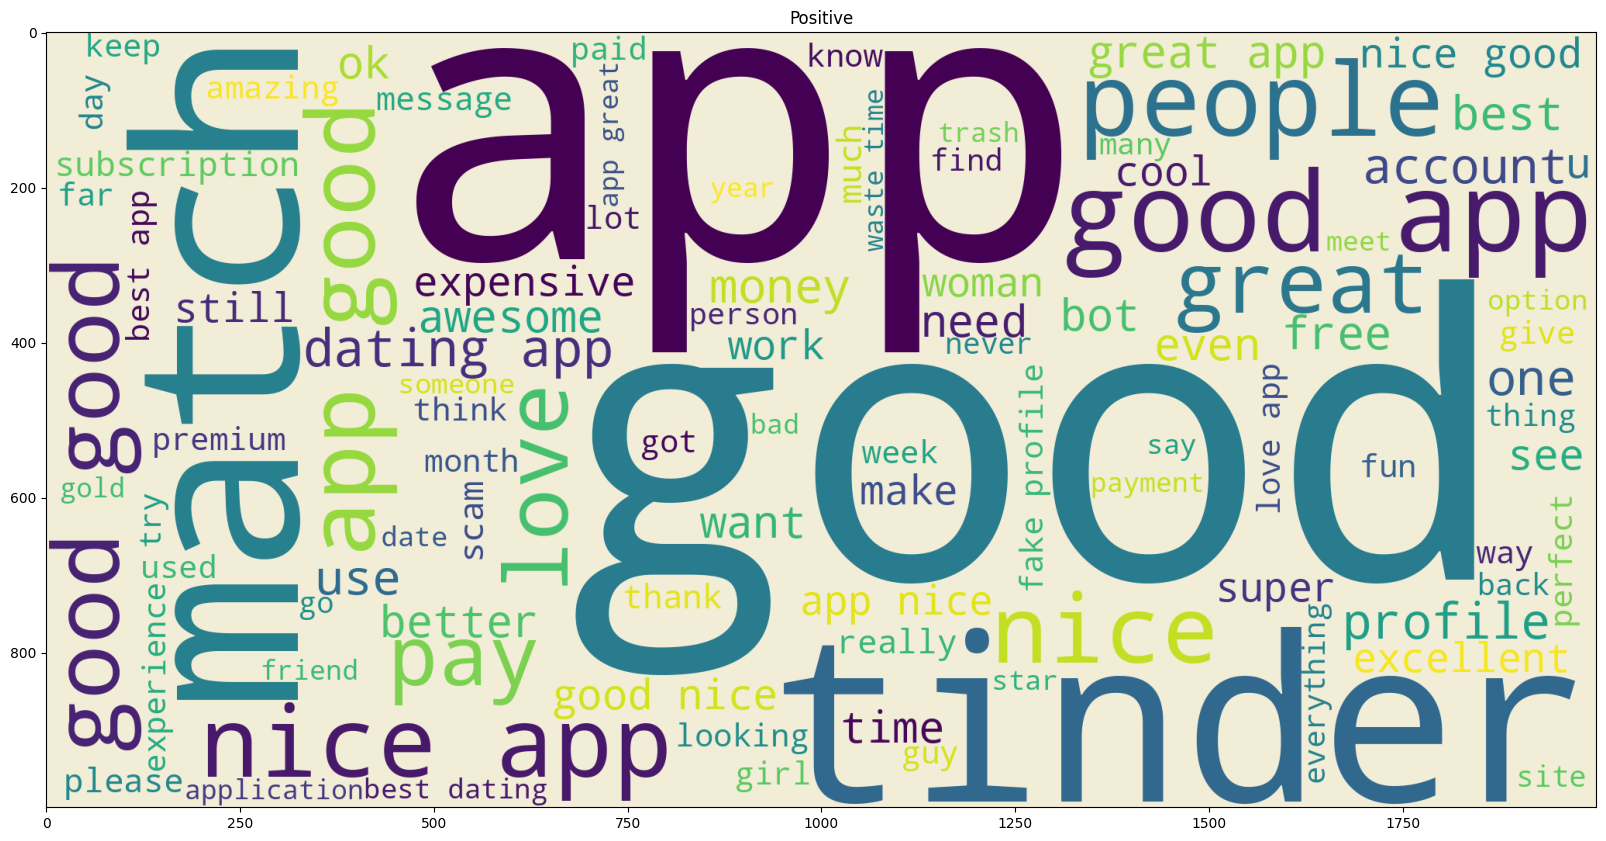

In [21]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(positive_all)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

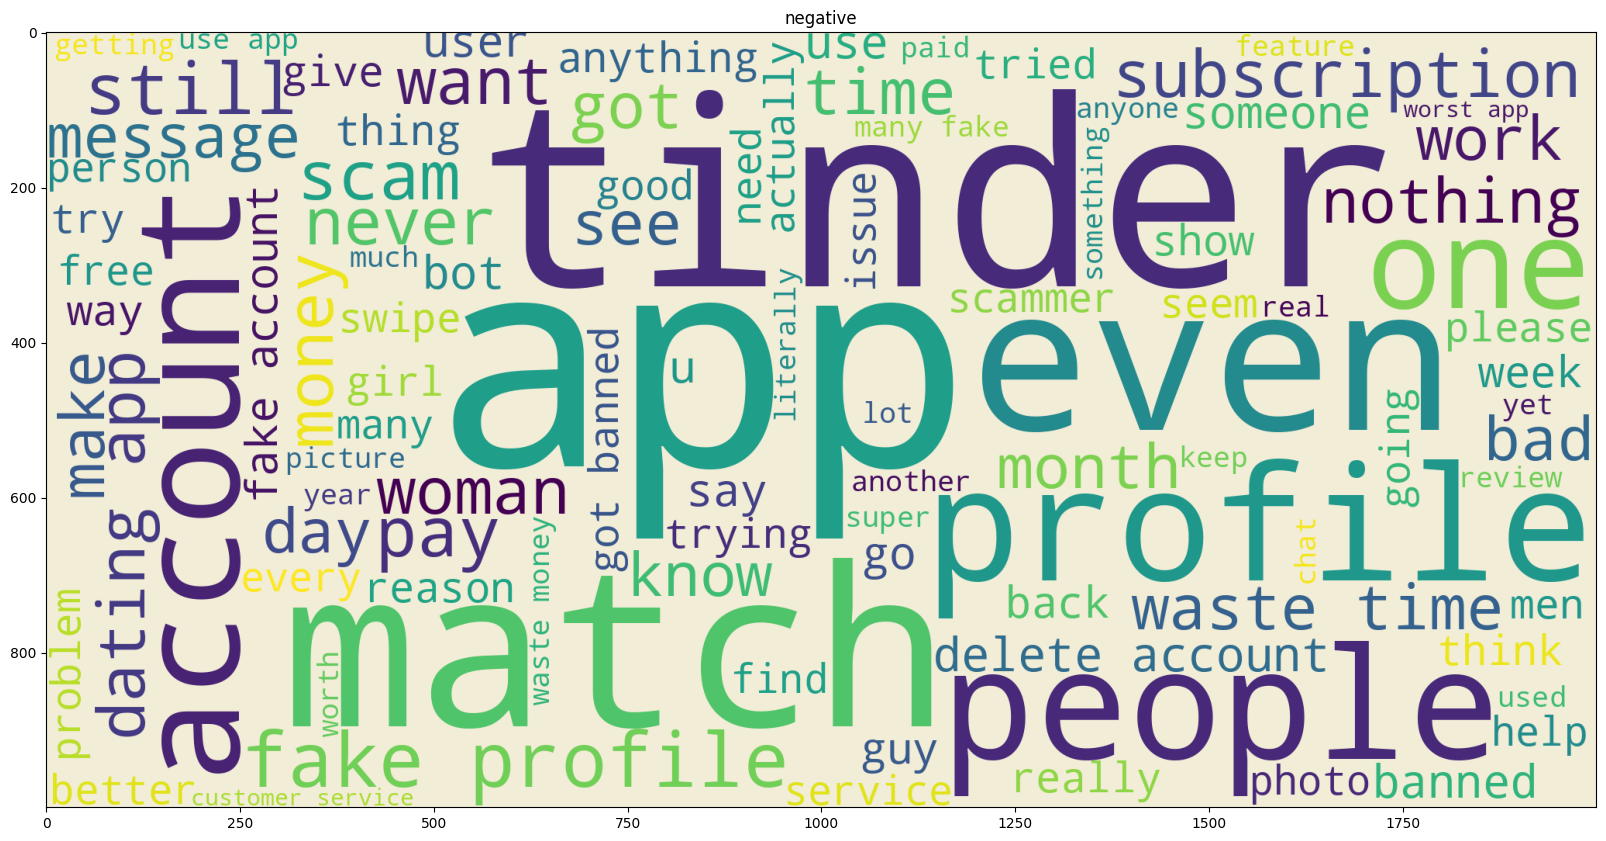

In [22]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(negative_all)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("negative")
plt.show()

Inference:

- Positive data has words like Thank, love , LOL, Haha ets
- Negative data has words like work, sad, tired, suck sorry
Some of the words are still common in both such as Lol, quot

In [23]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1

    return(dic)
count_corpus = get_count(positive_list)

In [24]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

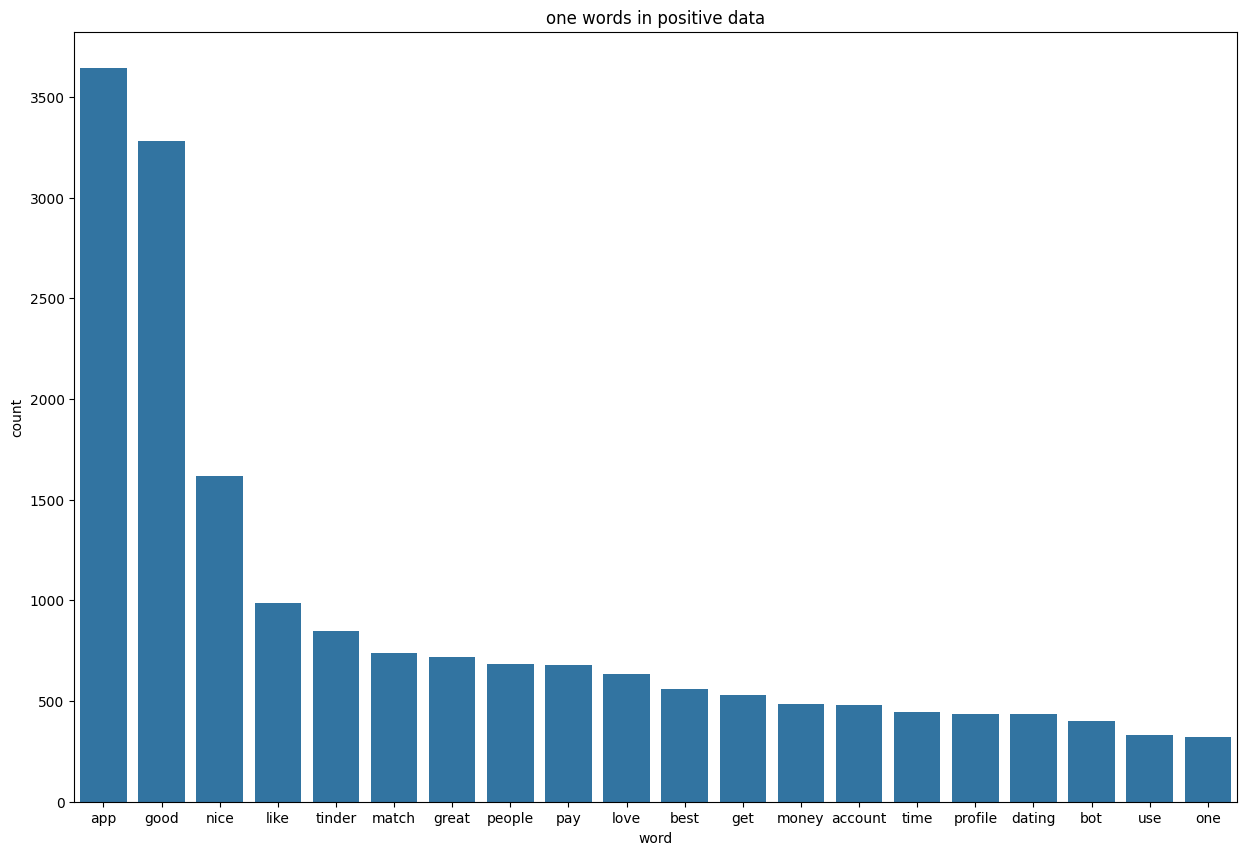

In [25]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.title('one words in positive data')
plt.show()

In [26]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1

    #dic = dict(sorted(dic.items() , key = lambda x:x[1],reverse=True))
    return(dic)
count_corpus = get_count(negative_list)

In [27]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

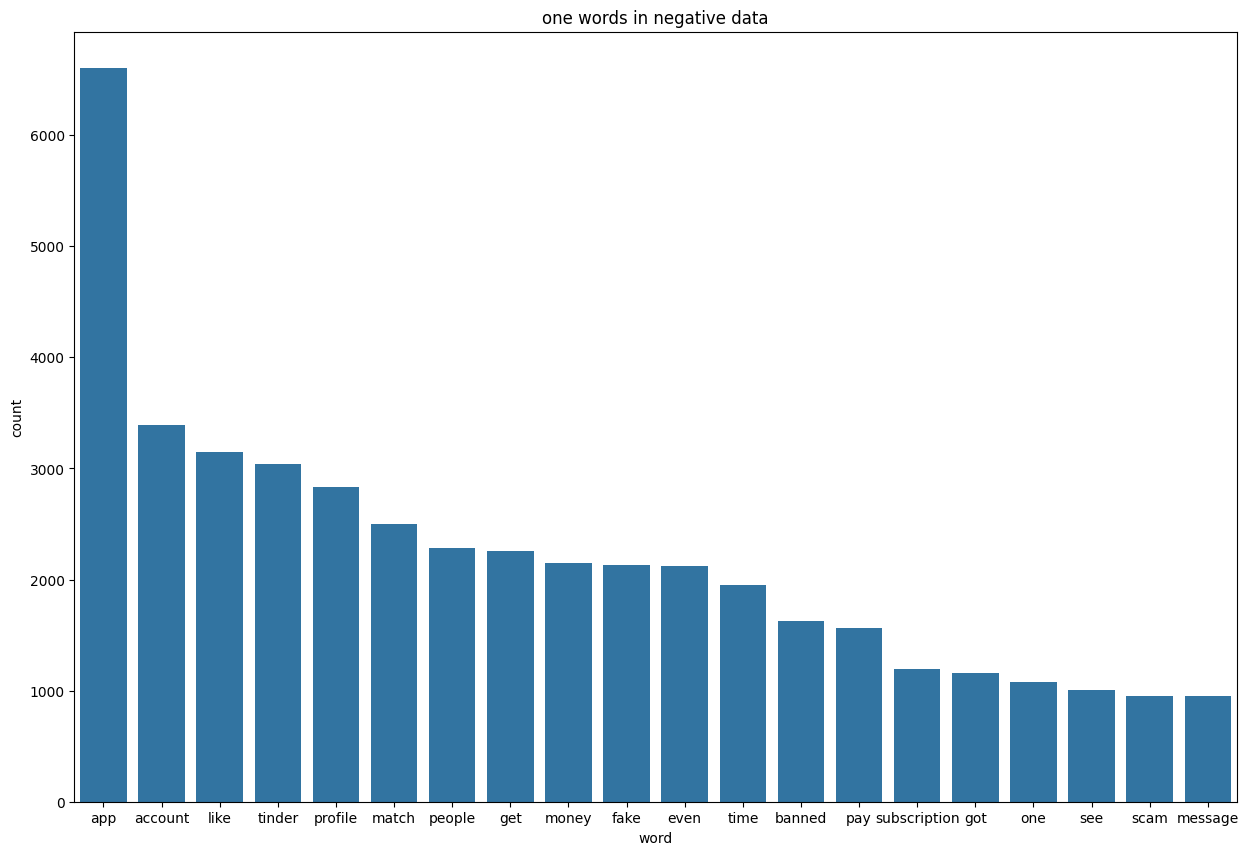

In [28]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.title('one words in negative data')
plt.show()

Inference
- Positive data has words like match, great, love, best
- Negative data has words like fake, banned, scam etc

# Naive Bayes

In [26]:
def get_tokens_for_model(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tokens)

positive_tokens_for_model = get_tokens_for_model(positive_list)
negative_tokens_for_model = get_tokens_for_model(negative_list)

In [27]:
import random

positive_dataset = [(review_dict, "Positive")
                     for review_dict in positive_tokens_for_model]

negative_dataset = [(review_dict, "Negative")
                     for review_dict in negative_tokens_for_model]
dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

In [28]:
split_index = int(len(dataset) * 0.7)
train_data = dataset[:split_index]
test_data = dataset[split_index:]

In [ ]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print(" Training Accuracy is:", round(classify.accuracy(classifier, train_data),2)*100)

print("Testing Accuracy is:", round(classify.accuracy(classifier, test_data),2)*100)

print(classifier.show_most_informative_features(10))
#COME BACK

 Training Accuracy is: 74.0
Testing Accuracy is: 73.0
Most Informative Features
                    poor = True           Negati : Positi =     90.7 : 1.0
               excellent = True           Positi : Negati =     70.3 : 1.0
             explanation = True           Negati : Positi =     64.6 : 1.0
                    hate = True           Negati : Positi =     59.5 : 1.0
                   wrong = True           Negati : Positi =     50.3 : 1.0
                   false = True           Negati : Positi =     42.6 : 1.0
                  failed = True           Negati : Positi =     38.7 : 1.0
                reported = True           Negati : Positi =     35.7 : 1.0
              ridiculous = True           Negati : Positi =     34.2 : 1.0
                canceled = True           Negati : Positi =     33.3 : 1.0
None


# TFIDF for sentiment analysis :

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(data_cleaned['content'])
y = data_cleaned['sentiment']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vector,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42,
                                                    stratify = y)

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression

In [32]:
def metrics(y_train,y_train_pred,y_test,y_test_pred, save):
  print("training accuracy = ",round(accuracy_score(y_train,y_train_pred),2)*100)
  ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize = 'all')
  print(classification_report(y_train,y_train_pred))
  if save == 1 :
    confusion_matrix_path = f"{images_dir}/confusion_matrix_train.png"
    plt.savefig(confusion_matrix_path)
  plt.show()




  print("testing accuracy = ",round(accuracy_score(y_test,y_test_pred),2)*100)
  ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred,normalize = 'all')
  print(classification_report(y_test,y_test_pred))
  if save == 1 :
    confusion_matrix_path = f"{images_dir}/confusion_matrix_test.png"
    plt.savefig(confusion_matrix_path)
  plt.show()


# MULTINOMIAL NB

training accuracy =  86.0
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      8026
           1       0.95      0.79      0.86     10073

    accuracy                           0.86     18099
   macro avg       0.86      0.87      0.86     18099
weighted avg       0.87      0.86      0.86     18099



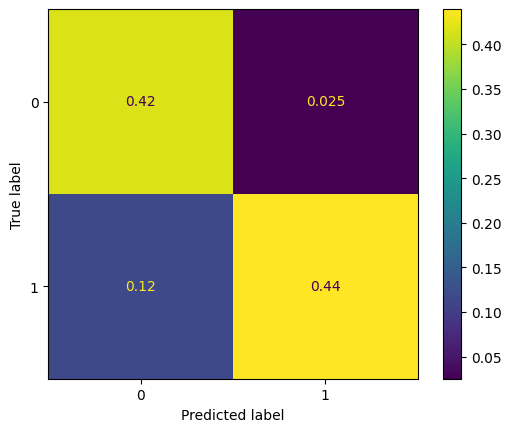

testing accuracy =  83.0
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      3953
           1       0.92      0.76      0.83      4962

    accuracy                           0.83      8915
   macro avg       0.83      0.84      0.83      8915
weighted avg       0.84      0.83      0.83      8915



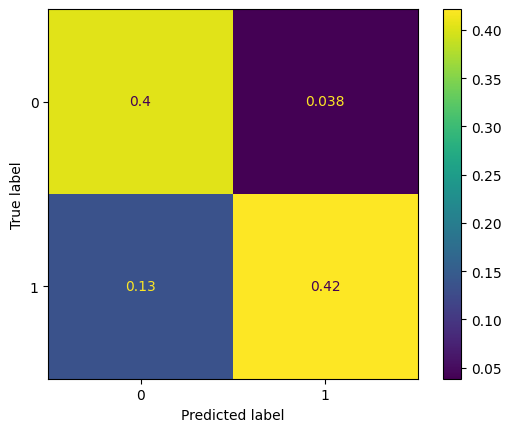

In [ ]:
NB = MultinomialNB()
NB.fit(X_train,y_train)
y_train_pred = NB.predict(X_train)
y_test_pred = NB.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred,0)

# LINEAR SVC

training accuracy =  94.0
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      8026
           1       0.96      0.94      0.95     10073

    accuracy                           0.94     18099
   macro avg       0.94      0.94      0.94     18099
weighted avg       0.94      0.94      0.94     18099



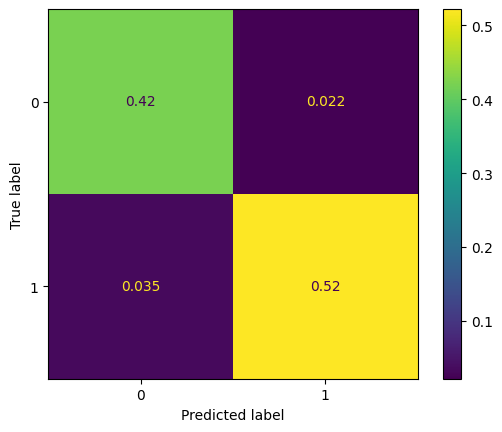

testing accuracy =  86.0
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      3953
           1       0.87      0.88      0.87      4962

    accuracy                           0.86      8915
   macro avg       0.85      0.85      0.85      8915
weighted avg       0.86      0.86      0.86      8915



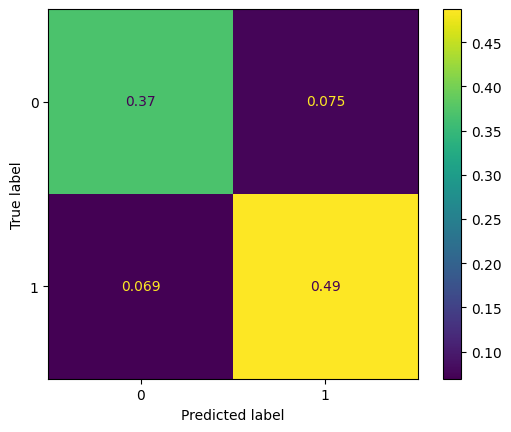

In [33]:
svc = LinearSVC()
svc.fit(X_train,y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred, 1)

# Logistic Regression

training accuracy =  89.0
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      8026
           1       0.91      0.89      0.90     10073

    accuracy                           0.89     18099
   macro avg       0.89      0.89      0.89     18099
weighted avg       0.89      0.89      0.89     18099



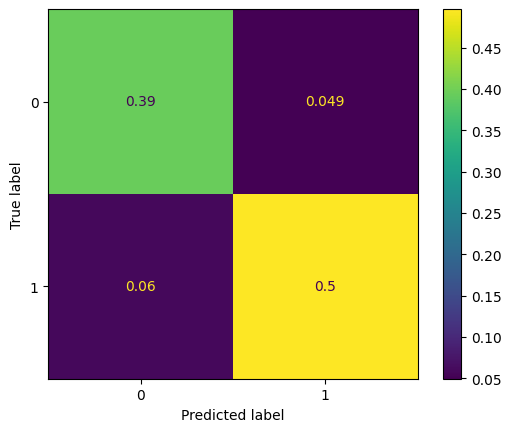

testing accuracy =  86.0
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      3953
           1       0.87      0.87      0.87      4962

    accuracy                           0.86      8915
   macro avg       0.85      0.85      0.85      8915
weighted avg       0.86      0.86      0.86      8915



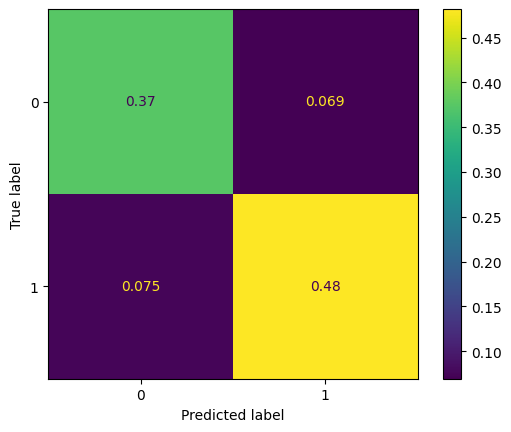

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred, 0)

# Storing the model in hopsworks

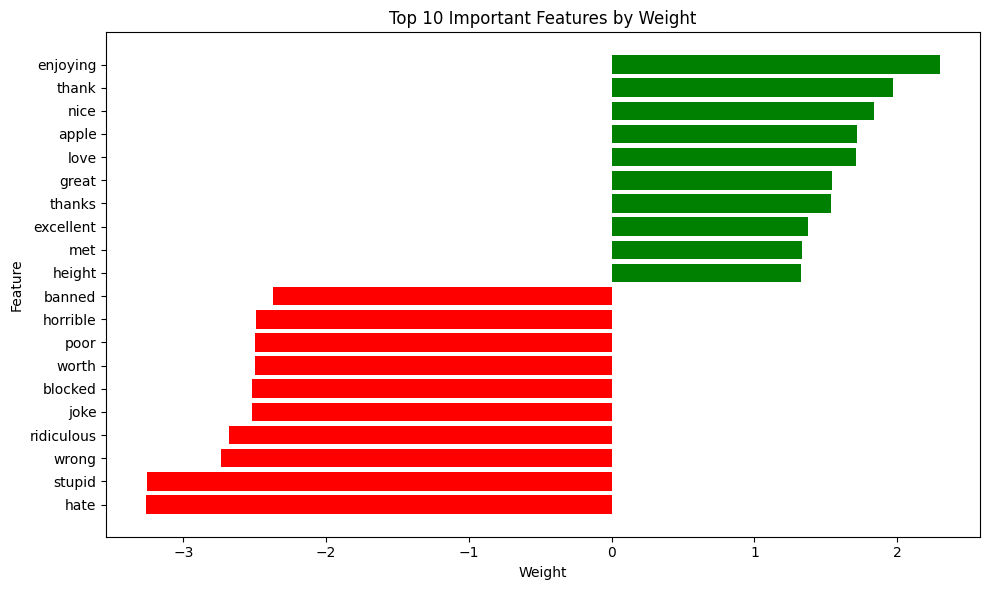

In [34]:


# Extract feature names and coefficients
feature_names = tfidf.get_feature_names_out()
coefficients = svc.coef_[0]

# Get the top 10 positive and negative features
top_positive_indices = np.argsort(coefficients)[-10:]  # Top positive weights
top_negative_indices = np.argsort(coefficients)[:10]   # Top negative weights

# Map indices to feature names and weights
top_positive_features = [(feature_names[i], coefficients[i]) for i in top_positive_indices]
top_negative_features = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

# Convert to DataFrame for easier plotting
df_features = pd.DataFrame(
    top_positive_features + top_negative_features,
    columns=["Feature", "Weight"]
)
df_features["Category"] = ["Positive"] * 10 + ["Negative"] * 10

# Plot feature importance
plt.figure(figsize=(10, 6))
df_features.sort_values(by="Weight", inplace=True)
plt.barh(df_features["Feature"], df_features["Weight"], color=["green" if c == "Positive" else "red" for c in df_features["Category"]])
plt.title("Top 10 Important Features by Weight")
plt.xlabel("Weight")
plt.ylabel("Feature")
plt.tight_layout()

# Save the feature importance plot
feature_importance_path = f"{images_dir}/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()




In [35]:
import numpy as np

# Convert X_train to a dense numpy array
if isinstance(X_train, np.ndarray) == False:
    X_train = X_train.toarray()

if isinstance(X_test, np.ndarray) == False:
    X_test = X_test.toarray()


In [36]:
import os
import joblib
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Save the LinearSVC model using joblib
joblib.dump(svc, f"{model_dir}/model.pkl")
print("Model saved as model.pkl")

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Define metrics (replace with your actual metrics)
res_dict = {
    "Accuracy": str(round(accuracy_score(y_test, svc.predict(X_test)), 4)),
}

# Access the model registry
mr = project.get_model_registry()

# Create the model in the model registry
svc_model = mr.python.create_model(
    name="linear_svc_model",
    metrics=res_dict,
    model_schema=model_schema,
    input_example=X_test[np.random.choice(X_test.shape[0], 1)],  # Provide an example input
    description="Sentiment analysis with LinearSVC",
)

# Save the model artifacts to the model registry
svc_model.save(model_dir)
print(f"Model saved successfully! Explore it at {svc_model.get_url()}")


Model saved as model.pkl


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/120779 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/14547 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/32494 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/17860 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/75233 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/239 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1185941/models/linear_svc_model/7
Model saved successfully! Explore it at https://c.app.hopsworks.ai:443/p/1185941/models/linear_svc_model/7


In [37]:
vectorizer_dir = "../vectorizer"
if not os.path.exists(vectorizer_dir):
    os.mkdir(vectorizer_dir)
joblib.dump(tfidf, f"{vectorizer_dir}/vectorizer.pkl")
# Access the model registry
mr = project.get_model_registry()

# Create the model in the model registry
vectorizer_model = mr.python.create_model(
    name="vectorizer",
    #metrics={},
    #model_schema=ModelSchema(),
    #input_example=[],
    description="Vectorizer for LinearSVC",
)
vectorizer_model.save(vectorizer_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/310413 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1185941/models/vectorizer/3


Model(name: 'vectorizer', version: 3)

In [38]:
print(len(tfidf.vocabulary_))

15006
